<a href="https://colab.research.google.com/github/drawcodeboy/Cat_n_Dog_Classification/blob/main/ver2(2)_cat_n_dog_data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from PIL import Image

In [ ]:
train_set = np.load('/content/drive/MyDrive/cat_n_dog/data_numpy/train_set.npy', allow_pickle=True)
test_set = np.load('/content/drive/MyDrive/cat_n_dog/data_numpy/test_set.npy', allow_pickle=True)

train_target = np.load('/content/drive/MyDrive/cat_n_dog/data_numpy/train_target.npy', allow_pickle=True)
test_target = np.load('/content/drive/MyDrive/cat_n_dog/data_numpy/test_target.npy', allow_pickle=True)

allow_pickle error
https://stackoverflow.com/questions/55890813/how-to-fix-object-arrays-cannot-be-loaded-when-allow-pickle-false-for-imdb-loa

In [ ]:
print(train_set.shape, train_target.shape, test_set.shape, test_target.shape)

(8005,) (8005,) (2023,) (2023,)


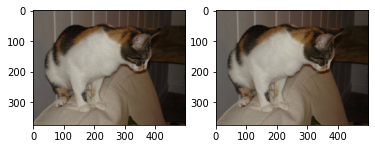

In [ ]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(train_set[0])
axs[1].imshow(train_set[0] / 255.0)

plt.show()

In [ ]:
# image_preprocessing: center cropping
def crop_center(img):
    y, x, z = img.shape
    crop_size = min(y, x)

    start_x = x // 2 - (crop_size // 2)
    start_y = y // 2 - (crop_size // 2)
    img = img[start_y:start_y + crop_size, start_x:start_x + crop_size]
    if crop_size < 224: # 확대 할 때, 바이큐빅 보간법
        return cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
    elif crop_size > 224: # 축소할 때, 영역 보간법
        return cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
    else:
        return img

reference: https://stackoverflow.com/questions/39382412/crop-center-portion-of-a-numpy-image

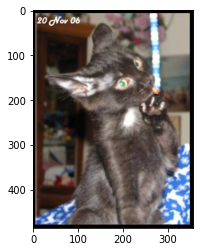

In [ ]:
 plt.imshow(train_set[2])

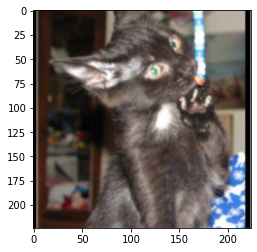

In [ ]:
plt.imshow(crop_center(train_set[2]))

In [ ]:
# Image Augmentation
train_scaled = []

cX, cY = 112, 112

for i, img in enumerate(train_set):
    img_crop = crop_center(img)

    # Gray Scaling -> 메모리 줄이기 위한 목적을 사용
    img_gray = cv2.cvtColor(img_crop, cv2.COLOR_BGR2GRAY)

    train_scaled.append(img_gray)
    # reverse left and right
    img_crop_rot90 = np.rot90(img_gray, k=2)
    img_crop_flip = np.flipud(img_crop_rot90)

    train_scaled.append(img_crop_flip)
    # right 45 Degree
    rot_r_45= cv2.getRotationMatrix2D((cX, cY), 45, 1.0)
    img_r_45 = cv2.warpAffine(img_gray, rot_r_45, (224, 224))

    train_scaled.append(img_r_45)
    # left 45 Degree
    rot_l_45= cv2.getRotationMatrix2D((cX, cY), -45, 1.0)
    img_l_45 = cv2.warpAffine(img_gray, rot_l_45, (224, 224))
    
    train_scaled.append(img_l_45)

train_scaled = np.array(train_scaled)

좌우반전 reference
https://www.kaggle.com/code/ichigoku/image-augmentation-using-numpy
특정 각도 rotation
https://yunwoong.tistory.com/125

(-0.5, 223.5, 223.5, -0.5)

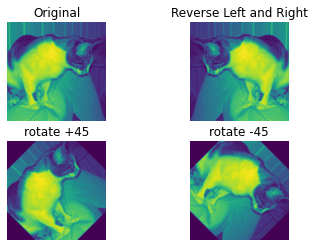

In [ ]:
fig, axs = plt.subplots(2, 2)

axs[0][0].imshow(train_scaled[0])
axs[0][0].set_title('Original')
axs[0][0].axis('off')

axs[0][1].imshow(train_scaled[1])
axs[0][1].set_title('Reverse Left and Right')
axs[0][1].axis('off')

axs[1][0].imshow(train_scaled[2])
axs[1][0].set_title('rotate +45')
axs[1][0].axis('off')

axs[1][1].imshow(train_scaled[3])
axs[1][1].set_title('rotate -45')
axs[1][1].axis('off')

In [ ]:
test_scaled = []

for i, img in enumerate(test_set):
    img_crop = crop_center(img)
    img_gray = cv2.cvtColor(img_crop, cv2.COLOR_BGR2GRAY)
    test_scaled.append(img_gray)

test_scaled = np.array(test_scaled, dtype=np.float32)

In [ ]:
# Image Augmentation에 따른 Target 데이터 늘리기

train_target_scaled = []

for target in train_target:
    for i in range(0, 4):
        train_target_scaled.append(target)

train_target_scaled = np.array(train_target_scaled)

In [ ]:
# 데이터 섞어주기
import random

shuffle_data = [[x, y] for x, y in zip(train_scaled, train_target_scaled)]
random.shuffle(shuffle_data)

x_train = [n[0] for n in shuffle_data]
y_train = [n[1] for n in shuffle_data]

x_train = np.array(x_train, dtype=np.float32) # RAM 위험
y_train = np.array(y_train)

문제점(해결)

Normalization을 통해 메모리가 uint8 -> float64로 넘어가면서 8배로 늘어나고, Image Augmentation을 통해 4배가 늘어나 런타임이 다운되는 상황이 일어난다.

float64 -> float32로 바꾸어 1/2배, Gray Scaling을 통해 1/3배한 후,
분산적 처리를 통해 해결한다.

Reference
https://jybaek.tistory.com/781

데이터를 섞어주지 않으므로써 fit 과정에서 비이상적인 현상이 일어났다.

Accuracy는 100%가 유지되지만 loss는 엄청 잠잠하다가 가끔 한 두번 거의 100 단위까지 뛰는 현상이 있었다.

이는 데이터를 섞어주지 않아 모델이 연속적으로 하나의 Target에 대해서만 학습하기 때문이었다.

In [ ]:
print(x_train.shape[0], y_train.shape[0])

32020 32020


In [ ]:
print(type(x_train[0][0][0]))
print(type(test_scaled[0][0][0]))

<class 'numpy.float32'>
<class 'numpy.float32'>


In [ ]:
# Normalization
x_train = x_train / 255.0
test_scaled = test_scaled / 255.0

In [ ]:
print(x_train[0][125][100])
print(type(x_train[0][125][100]))

0.3764706
<class 'numpy.float32'>


In [ ]:
def save_np(dataset, batch_size, save_path, file_name):
    max_batch_num = dataset.shape[0] // batch_size # 몇 번의 Batch로 나눌 수 있나
    max_batch_num = max_batch_num + 1 # 나머지 데이터도 Batch로 나눈다

    start = 0
    end = batch_size

    for file_index in range(1, max_batch_num):
        file_path = file_name + str(file_index)
        path_ = os.path.join(save_path, file_path)
        np.save(path_, dataset[start : end])

        start = start + batch_size
        end = end + batch_size
    
    last_file_path = file_name + str(max_batch_num)
    last_path_ = os.path.join(save_path, last_file_path)
    np.save(last_path_, dataset[start:])

In [ ]:
# 분산적 처리
save_np(x_train, 2000, '/content/drive/MyDrive/cat_n_dog/data_scaled_numpy/training_set_scaled', 'train_scaled_')
np.save('/content/drive/MyDrive/cat_n_dog/data_scaled_numpy/test_set_scaled/test_scaled', test_scaled)

In [ ]:
# train_target, train_set에 따른 분산처리
save_np(y_train, 2000, '/content/drive/MyDrive/cat_n_dog/data_scaled_numpy/train_target_part', 'train_target_')